<h3>Load data and prepare for Torch

In [1]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
 
df = pd.read_csv('data/face_data.csv')
n_persons = df['target'].nunique() 
X = np.array(df.drop('target', axis=1)) # 400 x 4096
y = np.array(df['target'])
 
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) # deafult test_size=0.25
 
# prepare data for PyTorch Tensor
X_train = torch.from_numpy(X_train).float() # convert to float tensor
y_train = torch.from_numpy(y_train).float() # 
train_dataset = TensorDataset(X_train, y_train) # create your datset
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
test_dataset = TensorDataset(X_test, y_test) # create your datset
 
# create dataloader for PyTorch
#切資料,不要一次全部丟到模型裡面
batch_size = 64 # 32, 64, 128, 256  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # convert to dataloader,要回頭做訓練
test_loader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False)

<h3>Set up NN Model

In [3]:
import torch.nn as nn #適合定義用的relu
import torch.nn.functional as F #適合用來使用的relu
 
# select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu" # run faster than cuda in some cases
print("Using {} device".format(device))
 
# Create a neural network
class MLP(nn.Module):
    def __init__(self):
        #定義模型內容: 隱藏層,神經元數量
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(64*64, 512), # image length 64x64=4096,  fully connected layer #allFace: 192*168
            nn.ReLU(), # try to take ReLU out to see what happen
            # nn.Linear(512, 512), # second hidden layer
            # nn.ReLU(),
            nn.Linear(512, 40) # 10 classes,  fully connected layer
            # nn.Softmax()
        )
    # Specify how data will pass through this model 輸出結果為機率
    def forward(self, x):
        # out = self.mlp(x) 
 
        # Apply softmax to x here~
        x = self.mlp(x)
        out = F.log_softmax(x, dim=1) # it’s faster and has better numerical propertie than softmax
        # out = F.softmax(x, dim=1)
        return out
 
 
# define model, optimizer, loss function
model = MLP().to(device) # start an instance
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # default lreaning rate=1e-3
loss_fun = nn.CrossEntropyLoss() # define loss function
 
print(model)

Using cpu device
MLP(
  (mlp): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=40, bias=True)
  )
)


test the forwards process of the nn model

In [13]:
input = torch.randn(100,64*64)
m1 = nn.Linear(64*64,512)
output=m1(input)
print(output.size())

output=F.relu(output) #使用
print(output.size())

m2= nn.Linear(512,40)
output=m2(output)
print(output.size())

output = F.log_softmax(output,dim=1)
print(output.size())

torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 40])
torch.Size([100, 40])


<h3>Start training

In [14]:
from tqdm import tqdm
 
epochs = 60 # Repeat the whole dataset epochs times
model.train() # Sets the module in training mode. The training model allow the parameters to be updated during backpropagation.
for epoch in tqdm(range(epochs)):
    trainAcc = 0
    samples = 0
    losses = []
    for batch_num, input_data in enumerate(train_loader):
    # for batch_num, input_data in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad() # Zeros the gradients accumulated from the previous batch/step of the model
        x, y = input_data
        x = x.to(device).float()
        y = y.to(device)
 
        # perform training based on the backpropagation
        y_pre = model(x) # predict y
        loss = loss_fun(y_pre, y.long()) # the loss function nn.CrossEntropyLoss()
        loss.backward() # Performs backpropagation
        losses.append(loss.item())
        optimizer.step() # Updates the weights in our neural network based on the results of backpropagation
         
        # Record the training accuracy for each batch
        trainAcc += (y_pre.argmax(dim=1) == y).sum().item() # comparison
        samples += y.size(0)
        # if batch_num % 40 == 0:
        #     print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
    # print('Epoch %d | Loss %6.2f | train accuracy %.4f' % (epoch, sum(losses)/len(losses), trainAcc/samples))
 
print('Finished ... Loss %7.4f | train accuracy %.4f' % (sum(losses)/len(losses), trainAcc/samples))


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]

Finished ... Loss  0.2816 | train accuracy 0.9929


<h3>Testing (1) : Compute test accuracy by batch

In [15]:
model.eval() 
testAcc = 0
samples = 0
with torch.no_grad():
    for x, y_truth in test_loader:
        x = x.to(device).float()
        y_truth = y_truth.to(device)
        y_pre = model(x).argmax(dim=1) # the predictions for the batch
        testAcc += (y_pre == y_truth).sum().item() # comparison
        samples += y_truth.size(0)
 
    print('Test Accuracy:{:.3f}'.format(testAcc/samples))

Test Accuracy:0.875


<h3>Testing (2): Compute the test accuracy and record the result for each test data

In [16]:
import csv
 
# use eval() in conjunction with a torch.no_grad() context, 
# meaning that gradient computation is turned off in evaluation mode
model.eval() 
testAcc = 0
samples = 0
 
with open('mlp_att.csv', 'w') as f:
    fieldnames = ['ImageId', 'Label', 'Ground_Truth']
    writer = csv.DictWriter(f, fieldnames=fieldnames, lineterminator = '\n')
    writer.writeheader()
    image_id = 1
 
    with torch.no_grad():
        for x, y_truth in test_loader:
            x = x.to(device).float()
            y_truth = y_truth.to(device).long()
            yIdx = 0
            y_pre = model(x).argmax(dim=1) # the predictions for the batch
            testAcc += (y_pre == y_truth).sum().item() # comparison
            samples += y_truth.size(0)
            for y in y_pre:
                writer.writerow({fieldnames[0]: image_id,fieldnames[1]: y.item(), fieldnames[2]: y_truth[yIdx].item()})
                image_id += 1
                yIdx += 1
 
        print('Test Accuracy:{:.3f}'.format(testAcc/samples))

Test Accuracy:0.875


<h3>_________________________________________________________<br>
PyTorch 的深度機器學習 CNN 範例：<br>
以手寫數字辨識為例<br>
_________________________________________________________<br>


Load and prepare data: 注意讀入的資料轉換為 Tensor 型態的過程。

In [14]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

mnist = loadmat("data/mnist-original.mat")


In [15]:
X = mnist["data"].T # 70000 x 784
y = mnist["label"][0]
 
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) # deafult test_size=0.25
 
# standaredize (may not be necessary)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
 
# convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_train = X_train.reshape(-1, 1, 28, 28) # convert to N x 1 x 28 x 28 for CNN (一小張黑白圖片的大小為28x28)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()
X_test = X_test.reshape(-1, 1, 28, 28) # N x 1 x 28 x 28 

 
# check shapes of data
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)
 
# create dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train.shape: torch.Size([56000, 1, 28, 28])
y_train.shape: torch.Size([56000])
X_test.shape: torch.Size([14000, 1, 28, 28])
y_test.shape: torch.Size([14000])


Define the network: 注意 convolution 採 zero-padding=0，即沒有 zero-padding，因此最後轉線性函數時，須留意計算經過幾層 convolution 及 max-pooling 後的影像矩陣大小。

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
 
class Net(nn.Module):
 
    def __init__(self):
        super(Net, self).__init__()
         
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 input channel, 6 output channels, 5x5 square convolution ->(N,6,24,24)-pool->(N,6,12,12)
        self.conv2 = nn.Conv2d(6, 16, 5) # 接著前面的output, 6 input channel, 16 output channels, 5x5 square convolution ->(N,16,8,8)-pool->(N,16,4,4)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 接著前面的output, 4*4 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 output classes
 
    def forward(self, x):
         
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
 
 
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
 
net = Net().to(device)
print(net)

Using cpu device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Test to see the layer output for various settings

In [34]:
input = torch.randn(128, 1, 28, 28) # 20 random 28 x 28 images with
#layer1
m= nn.Conv2d(1, 6, 5, stride=1)
output = m(input)
print(output.shape)
output = F.max_pool2d(F.relu(output),(2,2))
print(output.shape)

#layer2
m = nn.Conv2d(6, 16,5, stride=1)
output = m(output)
print(output.shape)
output = F.max_pool2d(F.relu(output), 2)
print(output.shape)
output = torch.flatten(output, 1)
print(output.shape)

m=nn.Linear(16*4*4, 120)
output=m(output)
print(output.shape)

m=nn.Linear(120, 84)
output=m(output)
print(output.shape)

m=nn.Linear(84, 10)
output=m(output)
print(output.shape)

torch.Size([128, 6, 24, 24])
torch.Size([128, 6, 12, 12])
torch.Size([128, 16, 8, 8])
torch.Size([128, 16, 4, 4])
torch.Size([128, 256])
torch.Size([128, 120])
torch.Size([128, 84])
torch.Size([128, 10])


觀察將進入訓練的影像資料，並試做 network 是否設計有誤

(1, 10)
tensor([[-0.0066,  0.0612,  0.0862, -0.0650,  0.0348,  0.0676,  0.0141, -0.0371,
          0.0106, -0.0316]])
tensor([[2]])
[[-0.0066422   0.06115761  0.08617689 -0.06503701  0.03481562  0.06758615
   0.01411347 -0.03710762  0.01055825 -0.03159628]]
torch.Size([128, 1, 28, 28])


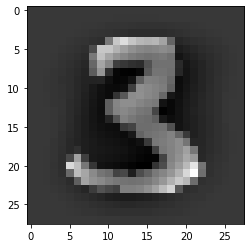

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


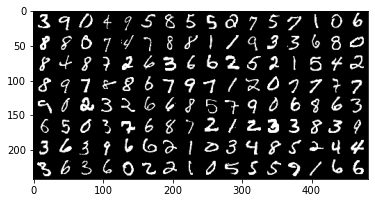

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
 
input = train_dataset[0][0].reshape(1, 1, 28, 28)
# 觀察 network 輸出結果
out = net(input.to(device))
print(out.to("cpu").detach().numpy().shape)
print(out.data)
print(out.data.max(1, keepdim=True)[1])
print(out.to("cpu").detach().numpy())
 
# get some random training images
dataiter = iter(train_loader) # an iterable object
images, labels = next(dataiter) # get the next batch
print(images.shape)
 
# show a single image
a_image = images[0]
a_image_ = np.transpose(a_image, (1, 2, 0))
plt.imshow(a_image_, cmap='gray')
plt.show()
 
# show a grid of images
montage = torchvision.utils.make_grid(images, nrow=16) # make a grid of images with 16 images per row
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray')
plt.show()

Define a Loss function and optimizer: use a Classification Cross-Entropy loss and SGD with momentum

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net2.parameters(), lr = 0.01) 

Train the network

In [22]:
epochs = 15
for epoch in range(epochs):  # loop over the dataset multiple times
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) # move to GPU if available
             
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs) # forward pass
        loss = criterion(outputs, labels) # compute loss
        # writer.add_scalar("Loss/train", loss, epoch)
        loss.backward() # compute gradients
        optimizer.step() # update weights
 
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[epoch : {epoch + 1}, batch: {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
 
print('Finished Training')

[epoch : 1, batch:   200] loss: 2.293
[epoch : 1, batch:   400] loss: 2.249
[epoch : 2, batch:   200] loss: 1.624
[epoch : 2, batch:   400] loss: 0.596
[epoch : 3, batch:   200] loss: 0.385
[epoch : 3, batch:   400] loss: 0.326
[epoch : 4, batch:   200] loss: 0.278
[epoch : 4, batch:   400] loss: 0.246
[epoch : 5, batch:   200] loss: 0.215
[epoch : 5, batch:   400] loss: 0.198
[epoch : 6, batch:   200] loss: 0.173
[epoch : 6, batch:   400] loss: 0.161
[epoch : 7, batch:   200] loss: 0.144
[epoch : 7, batch:   400] loss: 0.135
[epoch : 8, batch:   200] loss: 0.123
[epoch : 8, batch:   400] loss: 0.113
[epoch : 9, batch:   200] loss: 0.107
[epoch : 9, batch:   400] loss: 0.100
[epoch : 10, batch:   200] loss: 0.097
[epoch : 10, batch:   400] loss: 0.092
[epoch : 11, batch:   200] loss: 0.085
[epoch : 11, batch:   400] loss: 0.085
[epoch : 12, batch:   200] loss: 0.079
[epoch : 12, batch:   400] loss: 0.080
[epoch : 13, batch:   200] loss: 0.076
[epoch : 13, batch:   400] loss: 0.070
[epo

save the trained model for later use: 做為再次訓練的起點或訓練完成後的使用狀態

In [25]:
PATH = './digit10_net.pt' # .pth will collide with the PyTorch JIT
torch.save(net.state_dict(), PATH)

Test the network on the test data

In [26]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 97 %


Test on a random batch: 觀察部分測試的實際情況

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


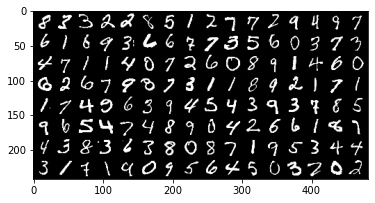

The predictions:
 {tensor([[8, 3, 3, 2, 2, 8, 5, 1, 2, 7, 7, 2, 9, 4, 9, 7],
        [6, 1, 6, 9, 3, 6, 6, 7, 7, 3, 5, 6, 0, 3, 7, 3],
        [4, 7, 1, 1, 4, 0, 7, 2, 6, 0, 8, 9, 1, 4, 0, 0],
        [6, 2, 6, 7, 9, 3, 7, 3, 1, 1, 8, 9, 2, 1, 7, 1],
        [1, 7, 4, 9, 6, 3, 9, 4, 5, 4, 3, 9, 3, 7, 8, 5],
        [9, 6, 5, 4, 7, 4, 8, 9, 0, 4, 2, 6, 6, 1, 3, 7],
        [4, 3, 8, 3, 6, 3, 8, 0, 8, 7, 1, 9, 5, 3, 4, 4],
        [3, 1, 7, 1, 9, 0, 9, 5, 6, 4, 5, 0, 3, 7, 0, 2]])}
Accuracy of the network on the 64 test images: 96.875 %


In [27]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
 
sample_idx = torch.randint(len(test_loader), size=(1,)).item()
dataiter = iter(test_loader)
for i in range(sample_idx): # randomly select a batch
    images, labels = next(dataiter)
 
# print test images
nrow = 16 # number of images per row
montage = torchvision.utils.make_grid(images, nrow=nrow)
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray')
plt.show()
 
# predict the labels
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print("The predictions:\n", {predicted.reshape(batch_size // nrow, nrow)})
 
total = labels.size(0)
correct_rate = (predicted == labels.to(device)).sum().item() / total
print(f'Accuracy of the network on the 64 test images: {100 * correct_rate} %')

採用第二種 network 結構 Net2：留意 convolution 的 zero-padding=2，造成後續影像矩陣大小的變化。另外，network 的輸出有兩項，第二項作為其他用途。

In [28]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10) # 32 * 7 * 7 is the size of the output of conv2
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1) # another way to flatten       
        output = self.out(x)
        return output, x    # return x for visualization
 
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
 
net2 = Net2().to(device)
print(net2)

Using cpu device
Net2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


Set up Loss function and optimizer

In [29]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters(), lr = 0.01)

Train the network

In [30]:
num_epochs = 15
def train(num_epochs, cnn, loaders):
     
    cnn.train()
         
    # Train the model
    total_step = len(loaders)
         
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders):
        
            b_x = images.to(device)   # batch x
            b_y = labels.to(device)   # batch y
            output = cnn(b_x)[0] # cnn output: get the first element of the returned tuple
                        
            loss = loss_func(output, b_y)
             
            # clear gradients for this training step   
            optimizer.zero_grad()           
             
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
             
            if (i+1) % 200 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
         
        pass
     
    pass
 
train(num_epochs, net2, train_loader)

Epoch [1/15], Step [200/438], Loss: 0.1897
Epoch [1/15], Step [400/438], Loss: 0.0194
Epoch [2/15], Step [200/438], Loss: 0.0143
Epoch [2/15], Step [400/438], Loss: 0.0399
Epoch [3/15], Step [200/438], Loss: 0.0427
Epoch [3/15], Step [400/438], Loss: 0.0268
Epoch [4/15], Step [200/438], Loss: 0.0057
Epoch [4/15], Step [400/438], Loss: 0.0254
Epoch [5/15], Step [200/438], Loss: 0.0585
Epoch [5/15], Step [400/438], Loss: 0.0414
Epoch [6/15], Step [200/438], Loss: 0.1198
Epoch [6/15], Step [400/438], Loss: 0.0490
Epoch [7/15], Step [200/438], Loss: 0.1098
Epoch [7/15], Step [400/438], Loss: 0.0364
Epoch [8/15], Step [200/438], Loss: 0.0575
Epoch [8/15], Step [400/438], Loss: 0.0854
Epoch [9/15], Step [200/438], Loss: 0.1537
Epoch [9/15], Step [400/438], Loss: 0.0436
Epoch [10/15], Step [200/438], Loss: 0.1791
Epoch [10/15], Step [400/438], Loss: 0.0769
Epoch [11/15], Step [200/438], Loss: 0.0093
Epoch [11/15], Step [400/438], Loss: 0.0068
Epoch [12/15], Step [200/438], Loss: 0.0993
Epoch 

Evaluate the model on test data

In [31]:
def test():
    # Test the model
    net2.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output, last_layer = net2(images.to(device))
            pred_y = torch.max(test_output, 1)[1]
            correct += (pred_y == labels.to(device)).sum().item()
            total += labels.size(0)
            # accuracy = (pred_y == labels.to(device)).sum().item() / float(labels.size(0))
            pass
    accuracy = correct / total
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
     
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.98


Print 10 predictions from test data

In [32]:
sample = next(iter(test_loader))
imgs, lbls = sample
ground_truth = lbls[:10].numpy()
print("Ground truth:\n", ground_truth)
 
test_output, last_layer = net2(imgs[:10].to(device))
pred_y = torch.max(test_output, 1)[1]
 
print("Prediction:\n", pred_y.cpu().numpy())


Ground truth:
 [4 5 0 1 5 7 1 5 0 5]
Prediction:
 [4 5 0 1 5 7 1 5 0 5]
